In [14]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import glob
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import toolbox
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

# create color map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255),
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# define pressure levels for interpolation
new_pressure_levels = [1., 1.21152771, 1.46779931, 1.77827942, 2.15443468, 2.61015725,    
                       3.1622777, 3.83118677, 4.64158869, 5.62341309, 6.81292057, 8.25404167, 
                       10. , 12.11527634, 14.67799282, 17.78279495, 21.54434776,   26.10157204, 
                       31.62277603,   38.31186676, 46.41588974,   56.23413086,   68.1292038 ,   
                       82.54042053, 100., 121.15276337, 146.77992249, 177.82794189, 215.44346619,  
                       261.01571655,  300.,  316.22775269, 350.,  400.,  450.,  500., 550., 600.,  
                       650.        ,  700.        , 750.        ,  775.        ,  800.        ,  
                       825.        ,850.        ,  875.        ,  900.        ,  925.        ,
                       950.        ,  975.        , 1000.        ]
    
# import ozone data (and zonal wind & temperature to remove QBO and ENSO)
O3_root_directory = '/home/disk/bdc2/aodhan/Zambri2020/O3*1995*'
T_root_directory = '/home/disk/bdc2/aodhan/Zambri2020/T*1995*'
U_root_directory = '/home/disk/bdc2/aodhan/Zambri2020/U*1995*'
O3_files = np.sort(glob.glob(O3_root_directory))
T_files = np.sort(glob.glob(T_root_directory))
U_files = np.sort(glob.glob(U_root_directory))


# get tropopause information from annual mean observations
def alt2pres(altitude):
    """
    Function to turn GNSS-RO derived tropopause height from Z coordinate
    to P coordinate.
    """
    
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press

# turn lrz to lrp
lrz = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/tempmaps/lrz_maps_zm_annual_mean.npy')
lrp = alt2pres(lrz)

In [15]:
# load O3 data
t_all_ens = []
u_all_ens = []
o3_all_ens = []
for file_idx, t_file in enumerate(T_files):
    
    # load temp, zonal wind, and oone
    xarray = xr.open_dataset(t_file).sel(time=slice('2002-01-01', '2022-12-31'))
    xarray_u = xr.open_dataset(U_files[file_idx]).sel(time=slice('2002-01-01', '2022-12-31'))
    xarray_o3 = xr.open_dataset(O3_files[file_idx]).sel(time=slice('2002-01-01', '2022-12-31'))
    
    # convert to pressure levels
    P0 = xarray.P0  # Reference pressure in Pa
    pressure = xarray['hyam'] * P0 + xarray['hybm'] * xarray['PS']
    standard_levels = xr.DataArray(new_pressure_levels, dims="level", name="pressure")
    
    # temp
    xarray = xarray.assign_coords(pressure=pressure)
    xarray = xarray.interp(lev=standard_levels)  # convert hPa to Pa
    
    # zonal wind
    xarray_u = xarray_u.assign_coords(pressure=pressure)
    xarray_u = xarray_u.interp(lev=standard_levels)
    
    # o3
    xarray_o3 = xarray_o3.assign_coords(pressure=pressure)
    xarray_o3 = xarray_o3.interp(lev=standard_levels)
    
    # define latitudes and levels
    lev = xarray.lev.values
    lats = xarray.lat.values
    
    # remove T climatologies
    t_data = xarray.T.values
    temp_cal = np.reshape(t_data, (21,12, len(lev), len(lats)))
    temp_seasonality = np.nanmean(temp_cal, axis=0)
    temp_anoms = temp_cal - temp_seasonality
    temp_anoms_ts = np.reshape(temp_anoms, (21*12, len(lev), len(lats)))
        
    # remove U climatologies
    u_data = xarray_u.U.values
    u_cal = np.reshape(u_data, (21,12, len(lev), len(lats)))
    u_seasonality = np.nanmean(u_cal, axis=0)
    u_anoms = u_cal - u_seasonality
    u_anoms_ts = np.reshape(u_anoms, (21*12, len(lev), len(lats)))
    
    # remove o3 climatologies
    o3_data_ppmv = xarray_o3.O3.values*1e6
    o3_cal = np.reshape(o3_data_ppmv, (21,12, len(lev), len(lats)))
    o3_seasonality = np.nanmean(o3_cal, axis=0)
    o3_anoms = o3_cal - o3_seasonality
    o3_anoms = np.divide(o3_anoms, o3_seasonality)*100
    o3_anoms_ts = np.reshape(o3_anoms, (21*12, len(lev), len(lats)))
    
    # create xarrays from data
    time = pd.date_range(start="2002-01-01", end="2022-12-01", freq='MS')
    t_anoms = xr.DataArray(temp_anoms_ts, coords={"time": time, "lev": lev, "lat": lats}, dims=["time", "lev", "lat"])
    u_anoms = xr.DataArray(u_anoms_ts, coords={"time": time, "lev": lev, "lat": lats}, dims=["time", "lev", "lat"])
    o3_anoms = xr.DataArray(o3_anoms_ts, coords={"time": time, "lev": lev, "lat": lats}, dims=["time", "lev", "lat"])
    
    # append data
    t_all_ens.append(t_anoms)
    u_all_ens.append(u_anoms)
    o3_all_ens.append(o3_anoms)

# get concatenated ensemble members
ens_t = xr.concat(t_all_ens, dim='ens_num')
ens_u = xr.concat(u_all_ens, dim='ens_num')
ens_o3 = xr.concat(o3_all_ens, dim='ens_num')

# get ensemble means
ens_t_mean = ens_t.mean(dim='ens_num')
ens_u_mean = ens_u.mean(dim='ens_num')
ens_o3_mean = ens_o3.mean(dim='ens_num')

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


# Remove QBO and ENSO

In [16]:
# remove the interannual variability from each ensemble member and find trends
trends_all = []
o3_anoms_all = []
for ens_idx in range(10):
    
    # find ensemble member
    t_ens_data = ens_t.isel(ens_num=ens_idx)
    u_ens_data = ens_u.isel(ens_num=ens_idx)
    o3_ens_data = ens_o3.isel(ens_num=ens_idx)
    
    # remove ensemble mean from each ensemble memeber
    t_ens_data_mr = t_ens_data - ens_t_mean
    
    # get the internal variability
    Teq = t_ens_data_mr.sel(lat=slice(-15,15)).mean(dim='lat').values
    T500_anoms_ts = Teq[:,35]
    
    # get zonal wind at 30 hPa
    u30 = ens_u_mean.sel(lat=slice(-5,5)).mean(dim='lat').values
    u30_anoms_ts = u30[:,18]

    # get zonal wind at 10 hPa
    u10 = ens_u_mean.sel(lat=slice(-5,5)).mean(dim='lat').values
    u10_anoms_ts = u10[:,12]

    # remove the QBO and ENSO
    o3_anoms_data = toolbox.ENSO_QBO_remover(o3_ens_data.values, T500_anoms_ts, u10_anoms_ts, u30_anoms_ts)
    
    #reorganize array
    o3_anoms_data = np.swapaxes(o3_anoms_data, 0,2)
    o3_anoms_data = np.swapaxes(o3_anoms_data, 1,2)
    
    # find trends
    trend_map = toolbox.annual_trend_finder(o3_anoms_data)
    
    # append data
    trends_all.append(trend_map)
    o3_anoms_all.append(o3_anoms_data)


# trends for each ensemble
trends_all = np.array(trends_all)[:,:,:,0]

# ensemble mean trend
ens_mean_anom = np.nanmean(o3_anoms_all, axis=0)
mean_trend = toolbox.annual_trend_finder(ens_mean_anom)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


# Ensemble mean trend

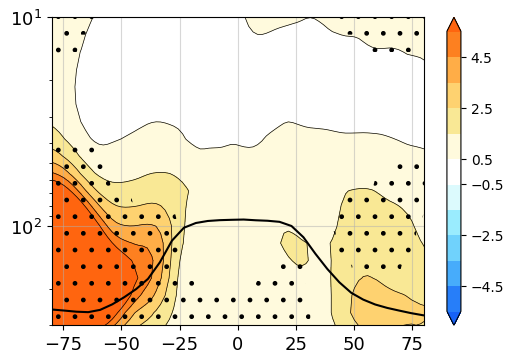

In [17]:
# define levels for plotting
levels = np.arange(-.55,.551,.1)*10

# set up plot size
fig, axs = plt.subplots(1, 1, figsize=(6,4))
    
# create contour plot with ensemble mean trend
plt.contour(lats, lev, mean_trend[:,:,0], levels=levels, colors='black', 
            extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
im = plt.contourf(lats, lev, mean_trend[:,:,0], levels=levels, cmap=custom_cmap, extend='both')

# plot tropopause and significance and model AWLS region
plt.plot(np.linspace(-90,90,36), lrp, color='black')
plt.contourf(lats, lev, mean_trend[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# set plotting parameters
axs.set_yscale('log')
axs.invert_yaxis()
axs.set_xlim(-80,80)
axs.set_ylim(300,10)
axs.grid(alpha=0.5)
cbar = plt.colorbar(im)
cbar.set_ticks(np.array([-0.45,-0.25, -0.05, 0.05, 0.25,0.45])*10)
x_vals = [-75, -50, -25, 0, 25, 50, 75]
plt.xticks(x_vals)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/WACCMTempEnsMean.png', dpi=300)


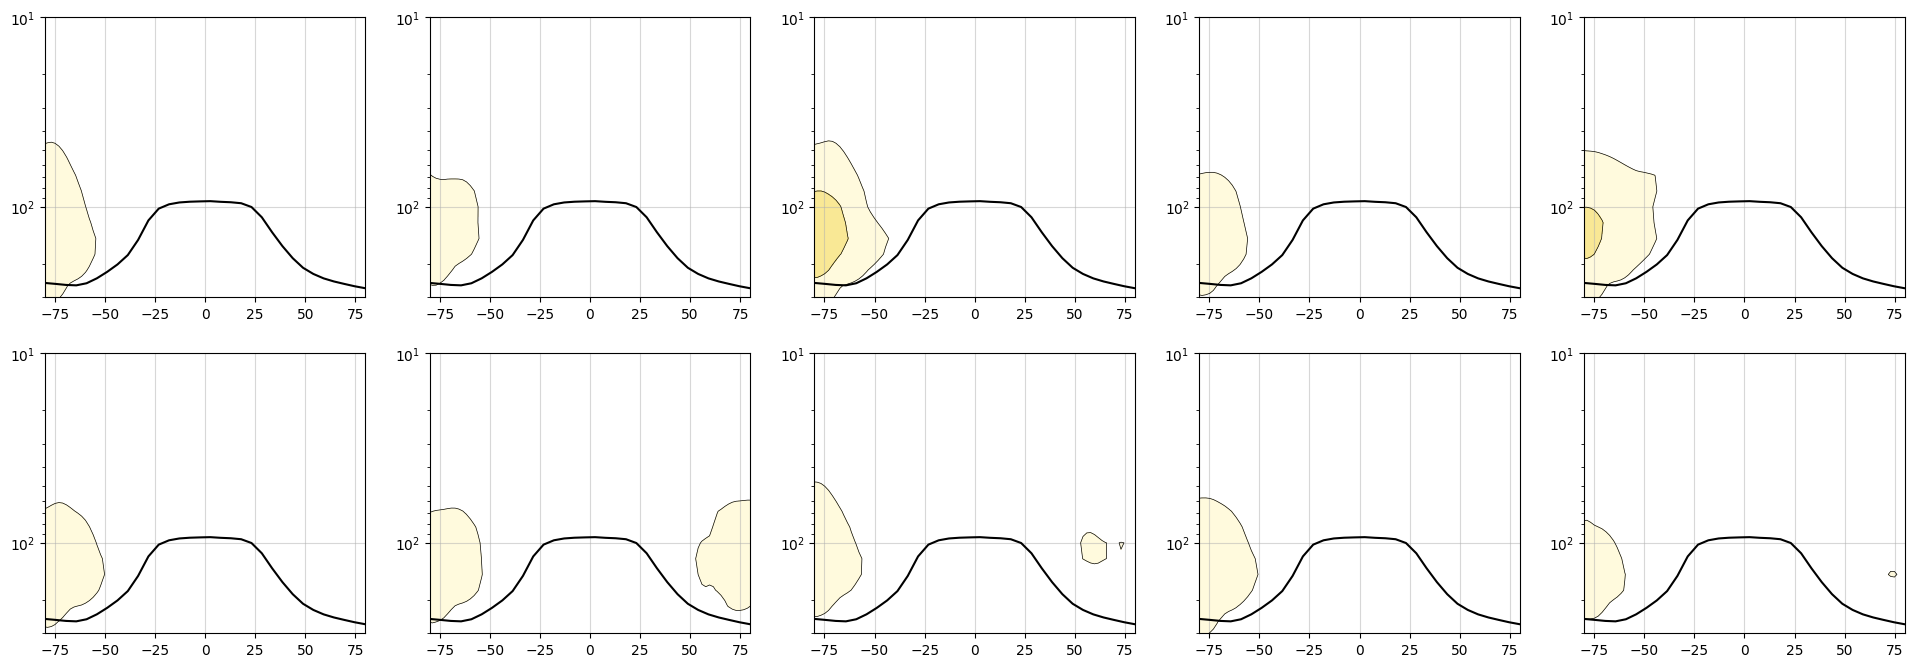

In [22]:
fig, axs = plt.subplots(2,5, figsize=(24,8))
axes = axs.ravel()

for i in range(0, len(axes)):
    ax = axes[i]
    ax.contour(lats, lev, trends_all[i,:,:], levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    im = ax.contourf(lats, lev, trends_all[i,:,:], levels=levels,cmap=custom_cmap, extend='both')
    #ax.contourf(lats, lev, trends_all[i,:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    ax.plot(np.linspace(-90,90,36), lrp, color='black')
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xlim(-80,80)
    ax.set_ylim(300,10)
    ax.grid(alpha=0.5)
    #plt.colorbar(im)
    #plt.contourf(lats, lev, trends_all[i,:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    #rect = patches.Rectangle((-33.75, 80.), 15, 20, linewidth=2, edgecolor='red', facecolor='none')
    #plt.gca().add_patch(rect)

# Get monthly trends

In [18]:
# we only need the monthly trends, so we are going to use the circulation regression code,
# but input random value for the timeseries to preform regression with
filler_ts = np.random.rand(252)
jan  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 0)
feb  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 1)
mar  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 2)
apr  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 3)
may  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 4)
jun  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 5)
jul  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 6)
aug  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 7)
sep  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 8)
occ  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 9)
nov  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 10)
dec  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 11)


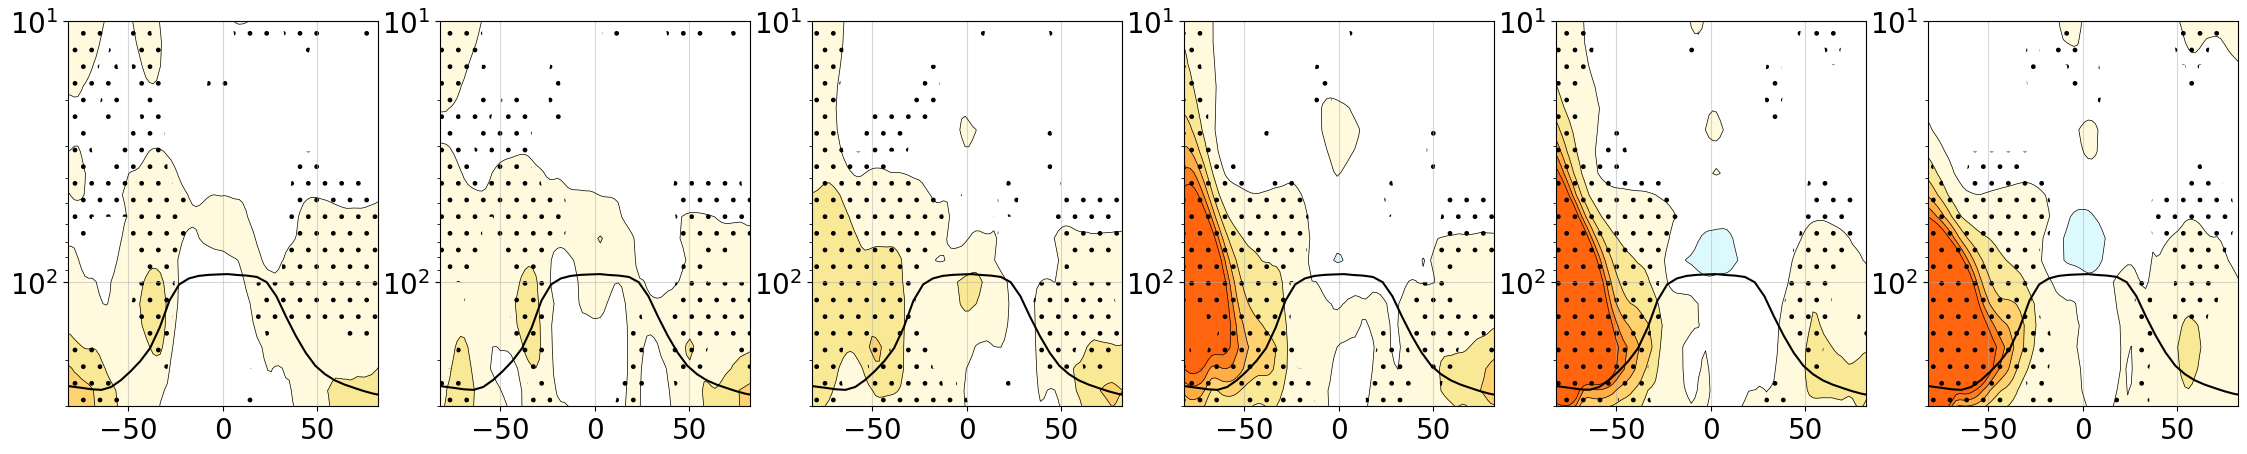

In [22]:
# define months
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

# choose months to plot
months = months2

# set plotting levels
levels = np.arange(-0.55,0.551,.1)*20

# create figure
fig, axs = plt.subplots(1,6, figsize=(28,5))
axes = axs.ravel()


for x in range(len(months1)):
    
    # plot contour
    axes[x].contour(lats, lev, months[x][:,:,0,0], levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(lats, lev,  months[x][:,:,0,0], levels=levels,cmap=custom_cmap, extend='both')
    
    # add significance and tropopause
    axes[x].contourf(lats, lev, months[x][:,:,0,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axs[x].plot(np.linspace(-90,90,36), lrp, color='black')    
    
    # add plotting parameters
    axs[x].set_yscale('log')
    axs[x].invert_yaxis()
    axes[x].set_ylim(300,10)
    axes[x].set_xlim(-82,82)
    axes[x].grid(alpha=0.5)
    axes[x].tick_params(axis='both', which='major', labelsize=20)